In [1]:
import math 
import numpy as np 
import pickle
import matplotlib.pyplot as plt
import os 
from matplotlib import rcParams, cycler
from scipy.stats import ttest_ind,  shapiro, mannwhitneyu, pearsonr
import seaborn as sb
import matplotlib.colors
import json

month = "03"
env_name = "spot_micro"
font = {'size'   : 18}

matplotlib.rc('font', **font)
colors =  ['#332288', '#117733', '#44AA99',
           '#88CCEE', '#DDCC77', '#CC6677',
           '#AA4499', '#882255', '#0A0A0A']*10

In [2]:
def bestSoFar(X):
    tmp = [X[0]]
    for x in X[1:]:
        tmp.append(max(tmp[-1], x))
    return tmp

In [3]:
def transform_action_to_motor_command(actions):
    motor_angle = np.copy(actions)
    scale_for_singularity = 1
    offset_for_singularity = 1.5
    num_motors = 8
    half_num_motors = int(num_motors / 2)
    quater_pi = np.pi / 4
    for i in range(num_motors):
        action_idx = int(i // 2)
        forward_backward_component = (-scale_for_singularity * quater_pi * 
                                      (actions[:, action_idx + half_num_motors] + offset_for_singularity))
        extension_component = (-1)**i * quater_pi * actions[:, action_idx]
        if i >= half_num_motors:
            extension_component = -extension_component
        motor_angle[:, i] = (np.pi + forward_backward_component + extension_component)
    return motor_angle
    
def plot_q_torque(directory, ep=-1, T1=0, T2=-1, j=0, run=0):
    path = "../exp/results/"+env_name+"_"+month+"/"
    file = "/run_"+str(run)+"/logs.pk"
    cf_file = "/run_"+str(run)+"/config.json"
    with open(path+directory+file, "rb") as f:
        data = pickle.load(f)
    with open(path+directory+cf_file, "r") as f:
        config = json.load(f)    
    acs = data['actions'][0]
    obs = data['observations'][0]
    obs_torques = data['observed_torques'][0]
    des_torques = data['desired_torques'][0]
    des_Tau = None
    X1 = [0.02*i for i in range(T1,T2)]
    if config['action_space'] == "Motor":
        Qd = acs[ep][T1:T2, j]*np.pi/4+1.5
        Q = obs[ep][T1:T2, j]
        Tau = 8*(Qd-Q)
        X2 = X1
    elif config['action_space'] == "S&E":
        se = acs[ep]
        se[:, :4] = se[:, :4]*0.75
        se[:, 4:] = (se[:, 4:] / 2 + 0.5) * 0.75 + 0.10
        Qd = transform_action_to_motor_command(se)[T1:T2, j]
        Q = obs[ep][T1:T2, j]
        Tau = 8*(Qd-Q)
        X2=X1
    elif config['action_space'] in ["Torque", "Torque2"]:
        Qd = obs[ep][T1:T2, j]
        if config['action_space'] == "Torque":
            Tau = 8*acs[ep][T1:T2, j]
        else:
            Tau = acs[ep][T1:T2, j]
#         plt.subplots(figsize=(16,9))
#         plt.hist(np.abs(Tau[1:]-Tau[:-1]))
        des_Tau = des_torques[ep][T1*5:T2*5, j]
        X2 = [0.004*(i) for i in range(T1*5+1, T2*5+1)]

    fig, ax  = plt.subplots(2, 1, figsize=(16,11))
    
    
    ax[0].plot(X1, Qd, lw=2, label="q_desired", color=colors[2])
    ax[0].scatter(X1, Qd, label="q_desired", color=colors[2])
    ax[0].axes.get_xaxis().set_visible(False)
    ax[0].set_title('Joint angle')
    
    if not des_Tau is None:
        ax[1].plot(X2, des_Tau, lw=1, label="Desired torque", color=colors[0])
    ax[1].scatter(X1, Tau, marker="o", label="Desired torque", color=colors[0])
    ax[1].set_title("Torque")
    
    true_torque = obs_torques[ep][T1*5:T2*5, j]
    X3 = [0.004*i for i in range(T1*5+1, len(true_torque)+T1*5+1)]
    ax[1].plot(X3, true_torque, lw=1, label="Observed torque", color=colors[1])
#     ax[1].scatter(X3, true_torque, marker="*", lw=1, label="Observed torque", color=colors[1])
    plt.xlabel("time (s)")
    plt.legend()

In [39]:
def WtE(X):
    Y = np.copy(X)
    for i in range(len(X)-2,-1,-1):
        Y[i] = min(Y[i], Y[i+1])
    return Y


def plot_x(subdirs, names=None, BsF=0, plot_time=0):
    if names is None:
        names = [str(i) for i in range(len(subdirs))]
    path = "../exp/results/"+env_name+"_"+month+"/"
    file = "/run_0/logs.pk"
    cf_file = "/run_0/config.json"
    
    Ls = []
    Vxs = []
    for directory in subdirs:
        with open(path+directory+file, "rb") as f:
            data = pickle.load(f)
        with open(path+directory+cf_file, "r") as f:
            config = json.load(f)
        obs = data['observations'][0]
        Vx = [np.sum(np.array(x)[:, -3])*config['ctrl_time_step'] for x in obs]
        L = [len(x)*config['ctrl_time_step'] for x in obs]
#         L = np.cumsum(L)/np.arange(1,len(L)+1)
        Ls.append(L)
        Vxs.append(Vx)
    
    foo = bestSoFar if BsF else lambda x: x
    plt.subplots(figsize=(16,9))
    for i in range(len(Vxs)):
        plt.plot(foo(Vxs[i]), lw=5, label=names[i], color=colors[i])
        X = [i for i in range(len(Vxs[i]))]
        plt.fill_between(X, bestSoFar(Vxs[i]), WtE(Vxs[i]), alpha=0.3,  color=colors[i])
        plt.plot(Vxs[i], lw=3, ls=":", color=colors[i])
    plt.legend()
    plt.ylabel('Forward distance (m)')
    plt.xlabel('Episodes')
    if plot_time:
        plt.subplots(figsize=(16,9))
        for i in range(len(Ls)):
            plt.plot(Ls[i], lw=5, label=names[i], color=colors[i])
        plt.legend()
        plt.ylabel('Episode Length (s)')
        plt.xlabel('Episodes')

In [40]:
test = "05_03_2020_09_58_55_experiment"
easier = "05_03_2020_10_13_22_experiment"

easier_not_smooth = "05_03_2020_10_32_39_experiment"

motor = "05_03_2020_14_12_40_experiment"
motor_smooth = "05_03_2020_14_57_59_experiment"

subdirs = [motor, motor_smooth]

directory = subdirs[-1]
names=['basic', 'smooth', 'on rack']

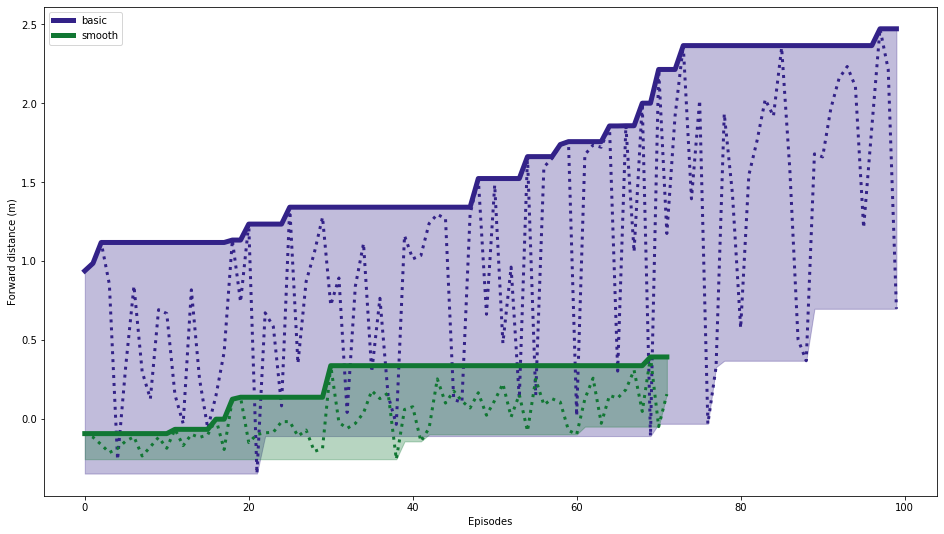

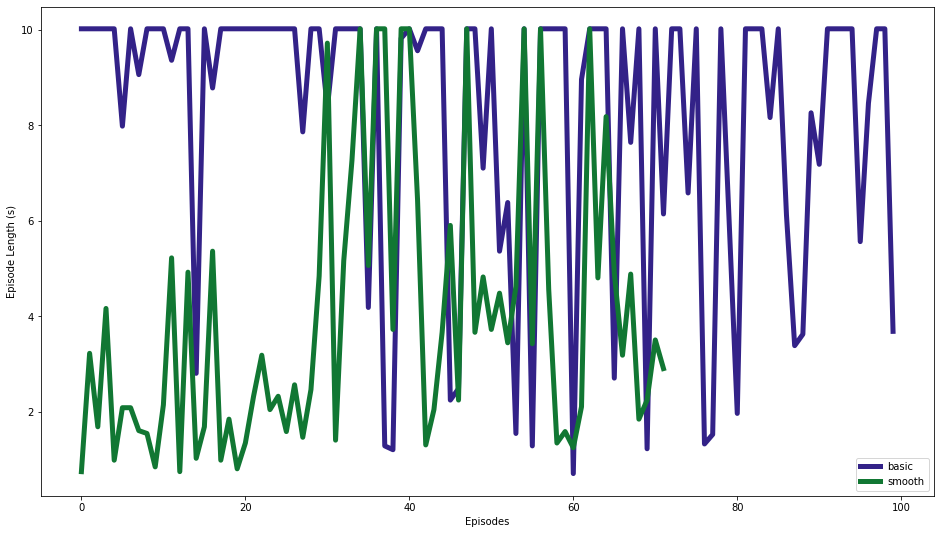

In [44]:
plot_x(subdirs, names=names, BsF=1, plot_time=1)

In [ ]:
plot_q_torque(subdirs[0], ep=-1, T1=0, T2=500, j=0, run=21)

In [12]:
def plot_action(subsirs, names, T1=0, T2=500, ep=-1, J=0):
    path = "../exp/results/"+env_name+"_"+month+"/"
    file = "/run_0/logs.pk"
    cf_file = "/run_0/config.json"
    Acs, dt = [], []
    for directory in subdirs:
        with open(path+directory+file, "rb") as f:
            data = pickle.load(f)
        with open(path+directory+cf_file, "r") as f:
            config = json.load(f)
        acs = data['actions'][0]
        Acs.append(acs)
        dt.append(config['ctrl_time_step'])
    fig, ax = plt.subplots(len(J), figsize=(16,9))
    if len(J) == 1:
        ax = [ax]
    for j in range(len(J)):
        for i in range(len(Acs)):
            Y = Acs[i][ep][T1:T2, J[j]]
            X = [dt[i]*j for j in range(len(Y))]
            ax[j].plot(X, Y, lw=1, label=names[i], color=colors[i])
            ax[j].scatter(X, Y, lw=1, color=colors[i])
            ax[j].set_xlabel("time (s)")
            ax[j].set_ylabel(["Abduction", "Swing", "Extension"][J[j]%3])
    ax[-1].legend()


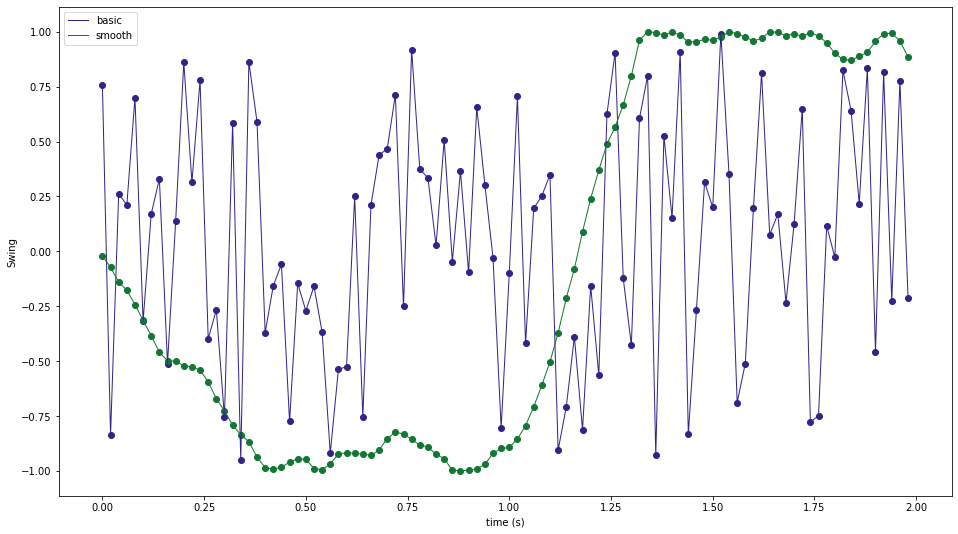

In [43]:
plot_action(subdirs, names, T1=0, T2=100, ep=-1, J=[1])

In [10]:
def plot_reward(subdirs, R_index=[0], names=None, foo=lambda x:x, log=False):
    if names is None:
        names = [str(i) for i in range(len(subdirs))]
    path = "../exp/results/"+env_name+"_"+month+"/"
    file = "/run_0/logs.pk"
    labels=['forward', 'z', 'roll', 'pitch', 'yaw', 'action norm', 'action vel', 'action acc', 'action_jerk']
    for r_index in R_index:
        Rs = []
        for directory in subdirs:
            with open(path+directory+file, "rb") as f:
                data = pickle.load(f)
            rewards = data['rewards'][0]
            R = [np.sum(r[:, r_index]) for r in rewards]
            Rs.append(R)

        plt.subplots(figsize=(16,9))
        for i in range(len(Rs)):
            plt.plot(foo(Rs[i]), lw=5, label=names[i], color=colors[i])
        if log:
            plt.yscale('log')
        plt.legend()
        plt.title(labels[r_index])
        plt.ylabel('Reward')
        plt.xlabel('Episodes')

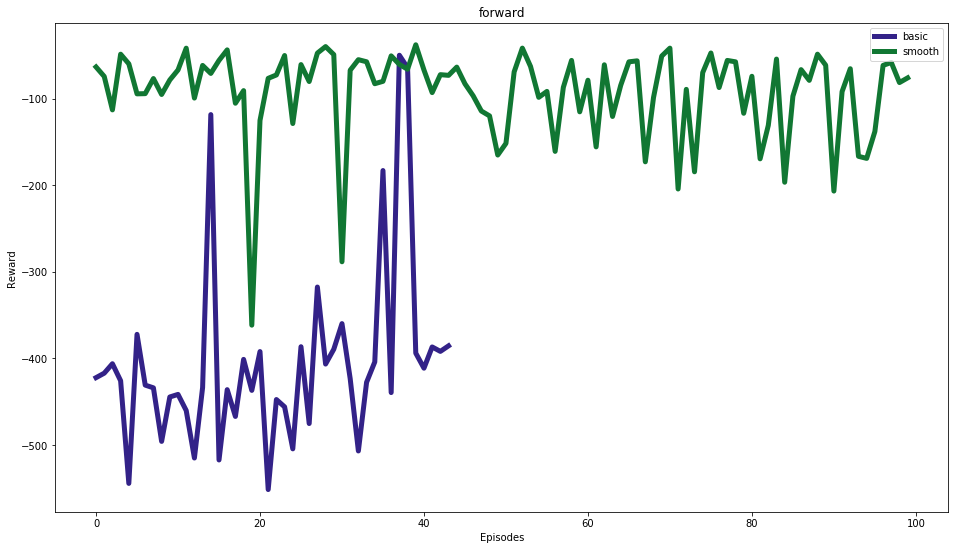

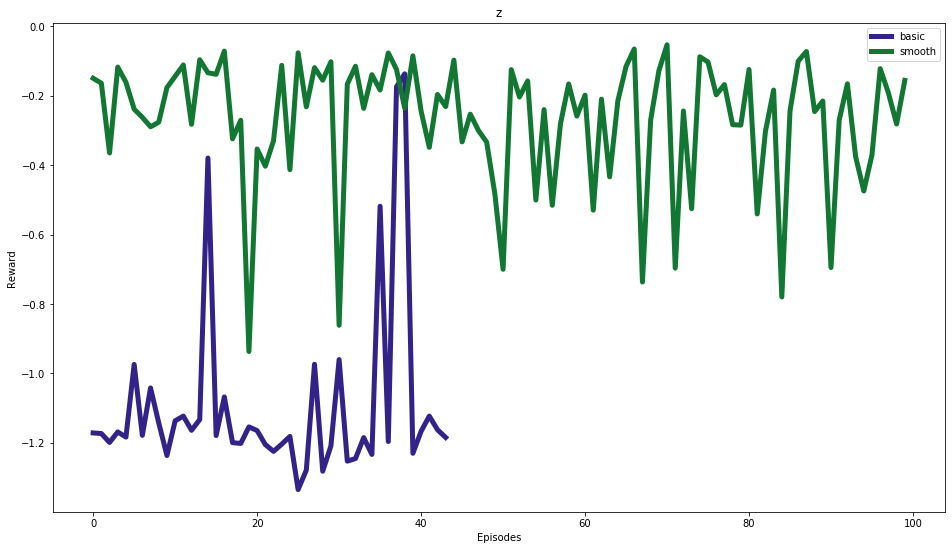

In [18]:
def my_exp(X):
    return np.exp(np.array(X))
identity = lambda x:x
plot_reward(subdirs, R_index=[0,1], names=names)

# Other

# Plot directory

In [ ]:
def plot_data(data, names, title, ylabel, foo=np.median, shade=True, yscale=None):
    plt.subplots(figsize=(16,9))
    for i in range(len(data)):
        Y = foo(data[i], axis=0)
        X = [i for i in range(len(Y))]
        color = colors[i%len(colors)]
        plt.plot(Y, lw=5, label=names[i], color=color)
        if shade:
            std = np.std(data[i], axis=0)
            plt.fill_between(X, Y-std, Y+std, alpha=0.3, color=color  )
        else:
            for j in range(len(data[i])):
                plt.plot(data[i][j], lw=2, color=color, alpha=0.3)
            
    plt.legend()
    plt.title(title)
    plt.xlabel("Episodes")
    plt.ylabel(ylabel)
    if not yscale is None:
        plt.yscale('log')

def compute_multi_run(directory, shape=[20,20], BsF=0):
    Ls, Vs = [], []
    index = 0
    foo = bestSoFar if BsF else lambda x:x
    for param in range(len(shape)):
        N = shape[param]
        L = []
        V = []
        for run in range(index, index+N):
            with open(path+directory+"/run_"+str(run)+file, "rb") as f:
                data = pickle.load(f)
            obs = data['observations'][0]
            v = [np.sum(np.array(x)[:, -3])*0.02 for x in obs]
            l = [len(x)*0.02 for x in obs]
            l = np.cumsum(l)/np.arange(1,len(l)+1)
            L.append(l)
            V.append(foo(v))
        Ls.append(L)
        Vs.append(V)
        index += N
    return Vs,Ls

In [ ]:


names = names
directory = popsize_speed 
path = "../fast_adaptation_embedding/exp/results/torque_minitaur_"+str(month)+"/"
file = "/logs.pk"

In [ ]:
indexes = [0,1,2,3,4,5]
Vs, Ls = compute_multi_run(directory, shape=[3]*34, BsF=1)
plot_data(np.array(Vs)[indexes], np.array(names)[indexes], shade=1,
               title="MPC population size", ylabel="distance (m)", foo=np.median)

In [ ]:
v = np.mean(np.array(Vs)[:, :, 90:], axis=(2))
indexes = [0,1,2]
data = list(v[indexes])
data_names = np.array(names)[indexes]
bbox = (1.05,0.4,0.3,0.5)
plot_boxplot(data, data_names, title="Desired speed", ylabel="distance (m)", bbox=bbox, comparison=False)

In [ ]:
def plot_data(X, names, title):
    N = len(X)
    assert N <= len(names)
    data = np.array(X).T
    cmap = plt.cm.plasma
    rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N)))
    plt.subplots(figsize=(16,9))
    plt.title(title)
    lines = plt.plot(data, lw=3)
    plt.legend(iter(lines), names)
    plt.xlabel("episodes")

def plot_one_for_each(directory, names, indexes=None, plot=True, dt=0.02, foo=lambda x:x):
    N = len(os.listdir(path+directory))-1
    if indexes is None: indexes = range(N)
    L = []
    V = []
    for run in indexes:
        with open(path+directory+"/run_"+str(run)+file, "rb") as f:
            data = pickle.load(f)
        obs = data['observations'][0]
        v = [np.sum(np.array(x[:, -3]))*dt for x in obs]
        l = [len(x)*dt for x in obs]
        l = np.cumsum(l)/np.arange(1,len(l)+1)
        L.append(l)
        V.append(foo(v))
    if plot:
        plot_data(V, names, title="Best Distance")
        plot_data(L, names, title="Average Episode Length")
    return V

In [ ]:
dt = 0.02
V = plot_one_for_each(directory, names, indexes=range(3), plot=0, dt=dt)

In [ ]:
V = np.array(V)
plt.subplots(figsize=(16,9))
X = [25*(i+1)*dt for i in range(len(V))]
Y = np.median(V[:, 50:], axis=1)
std = np.std(V[:, 50:], axis=1)
maxi = np.max(V[:, 50:], axis=1)
plt.plot(X,Y, lw=5, label='median')
plt.plot(X,maxi, lw=3, c="red", label="maximum")
plt.fill_between(X, Y-std, Y+std, alpha=0.3, label="std" )
plt.xlabel("Horizon (s)")
plt.ylabel('Distance (m)')
plt.legend()
plt.title("Performance for different Horizons")

# Plot test traj

In [ ]:
def plot_test(directory, names=None, BsF=0):
    if names is None:
        names = [str(i) for i in range(len(subdirs))]
    path = "../fast_adaptation_embedding/exp/results/torque_minitaur_"+month+"/"
    file = "/run_0/test_logs.pk"

    Vxs = []
    with open(path+directory+file, "rb") as f:
        data = pickle.load(f)
    obs = data['observations']
    for o in obs:
        Vx = [np.sum(np.array(x[:, -3]))*0.02 for x in o]
        Vxs.append(Vx)
    return Vxs

In [ ]:
test = "07_02_2020_11_12_06_experiment"
test0 = "07_02_2020_10_12_57_experiment"

directory = test0
names = ['test']

In [ ]:
b0 = plot_test(directory, names)

In [ ]:
b0 = baseline

# Plot Meta

In [ ]:
def plot_meta(directory, names=None, BsF=0):
    if names is None:
        names = [str(i) for i in range(len(subdirs))]
    path = "../fast_adaptation_embedding/exp_meta_learning_embedding/results/meta_torque_minitaur_"+month+"/"
    file = "/logs.pk"
    N = len(os.listdir(path+directory))-1
    Ls = []
    Vxs = []
    for run in range(N):
        with open(path+directory+"/run_"+str(run)+file, "rb") as f:
            data = pickle.load(f)
        obs = data['observations']
        Vx = [np.sum(np.array(x[:, -3]))*0.02 for x in obs]
        Vxs.append(Vx)
    return Vxs

In [ ]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

def compute_test(data, coef=1, N=5):
    pairs = []
    for i in range(N-1):
        for j in range(i+1,N):
            pairs.append((i,j))
    res = [[] for _ in range(N)]
    cells = [[ '' for _ in range(N-1)] for _ in range(N-1)]
    for (param1,param2) in pairs:
        data1 = np.array(data[param1])
        data2 = np.array(data[param2])
        stat, p_t = ttest_ind(data1,data2)
        p_t = p_t*coef
        mean1 = np.median(data1)
        mean2 = np.median(data2)
        d = truncate(mean1/mean2, 2)
        if d=='0.00' or d=='-0.00':
            d = truncate( mean1/mean2, 3)
            if d=='0.000' or d=='-0.000':
                d = truncate( mean1/mean2, 4)
                
        if p_t < 0.001:
            res.append((param1, param2, '***'))
            cells[param1][N-1-param2] = d+'\n***'
        elif p_t < 0.01:
            res.append((param1, param2, '**'))
            cells[param1][N-1-param2] = d+'\n**'
        elif p_t < 0.05:
            res.append((param1, param2, '*'))
            cells[param1][N-1-param2] = d+'\n*'
        else:
            cells[param1][N-1-param2] = "ns"
    return res,cells

def plot_boxplot(data, names, ylabel="performance", ylim=None, title="", log=False, bbox=(1.2,0.4,0.3,0.5),
                comparison=True):
    N = len(data)
    stat,cells = compute_test(data, 3*N*(N-1)/2, N)
    
    plt.subplots(figsize=(12,10) if comparison else (16,9))
    
    bplot = sb.boxplot(data=data)
    for i in range(N):
        bplot.artists[i].set_facecolor(colors[i])
    if np.size(data) < 1000:
        sb.swarmplot( data=data, color='black', edgecolor='black',size=7)
    if comparison:
        rows = names[:N-1]
        columns = [names[i] for i in range(N-1,0,-1)]
        cell_text = cells
        cellColours = [['white' if N-1-i>j else 'lightgrey' for j in range(N-1)] for i in range(N-1) ]
        the_table = plt.table(cellText=cell_text,
                              rowLabels=rows,
                              cellColours= cellColours,
                              rowColours=colors[:N-1],
                              colColours=[ colors[i] for i in range(N-1,0,-1)],
                              colLabels=columns,
                              cellLoc = 'center',
                              bbox=bbox)
    
    plt.xticks(range(N), names)
    if log:
        plt.yscale('log')
    if not ylim is None:
        plt.ylim(ylim)
    plt.ylabel(ylabel)
    plt.title(title)

In [ ]:
frictions = "07_02_2020_10_50_53_experiment"

directory = frictions
subdirs = [frictions]
names = ['Friction=0.25', 'Friction=3']

In [ ]:
meta_data = plot_meta(directory, names)

In [ ]:
b0[0][::3]

In [ ]:
for i in range(len(meta_data)):
    plot_boxplot([b0[0][::3], baseline[i], meta_data[i]], ['Baseline (f=1)', 'no adaptation', 'meta-learning'], 
                 ylabel="distance (m)", title=names[i])

[array([0.25289626, 0.71171126, 0.22098188])]